### Code to plot results from ABAQUS AM runs

This notebook allows one to read the output from abaqus runs to see what the melt pool looks like and to get the thermal history in the plane that cuts through the centre of the meltpool and shows the direction of beam travel

First cell contains a bunch of routines produced by SRC for loading the data and plotting data

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 29 15:08:01 2021

@author: Shaun
"""
from IPython.display import display
import numpy as np
import math
import matplotlib.pyplot as plt
import glob , os
import pylab as pylab
import gzip
from scipy.optimize import curve_fit
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib import animation
from scipy.special import erfc
from scipy.special import erf
from numpy import unravel_index
import matplotlib.tri as tri

def readfiles(nm,zv):
        
    x = []
    y = []
    z = []
    T = []

    with gzip.open(nm) as f:
        lines = [line.decode('utf8').strip(" ").split(" ") for line in f]
    
    header = lines[0]
    time = header[1]
    lines[0:1]=[]
    
    if len(lines) > 0:
        for line in lines:
            line = [i for i in line if i] 
            x.append(float(line[0]))
            y.append(float(line[1]))
            z.append(float(line[2]))
            T.append(float(line[3]))
    
        zvals = np.unique(z)
        ind = np.where(np.asarray(z)==zvals[zv])
        x = np.asarray(x)
        y = np.asarray(y)
        T = np.asarray(T)

        X = x[ind]
        Y = y[ind]
        T = T[ind]
    
    else:
        X = []
        Y = []
        T = []
        
    return X,Y,T,time

def readfilesYZ(nm,xv):
        
    x = []
    y = []
    z = []
    T = []

    with open(nm) as f:
        lines = [line.strip(" ").split(" ") for line in f]
    
    header = lines[0]
    time = header[1]
    lines[0:1]=[]
    
    if len(lines) > 0:
        for line in lines:
            line = [i for i in line if i] 
            x.append(float(line[0]))
            y.append(float(line[1]))
            z.append(float(line[2]))
            T.append(float(line[3]))
    
        xvals = np.unique(x)
        ind = np.where(np.asarray(x)==xvals[xv])
        y = np.asarray(y)
        z = np.asarray(z)
        T = np.asarray(T)

        Y = y[ind]
        Z = z[ind]
        T = T[ind]
    
    else:
        Y = []
        Z = []
        T = []
        
    return Y,Z,T,time
        
def readfilestop(nm,zv):
        
    x = []
    y = []
    z = []
    T = []

    with open(nm) as f:
        lines = [line.strip(" ").split(" ") for line in f]
    
    header = lines[0]
    time = header[1]
    lines[0:1]=[]
    
    if len(lines) > 0:
        for line in lines:
            line = [i for i in line if i] 
            x.append(float(line[0]))
            y.append(float(line[1]))
            z.append(float(line[2]))
            T.append(float(line[3]))
    
        yvals = np.unique(y)
        ind = np.where(np.asarray(y)==yvals[zv])
        x = np.asarray(x)
        z = np.asarray(z)
        T = np.asarray(T)

        X = x[ind]
        Z = z[ind]
        T = T[ind]
    
    else:
        X = []
        Z = []
        T = []
        
    return X,Z,T,time



def readalldata(fnames):

    Xtot = []
    Ytot = []
    Ttot = []
    timetot = []

    for i in range(len(fnames)):
        nm = fnames[i]
        X,Y,T,t = readfiles(nm,-1)
        if len(X) > 0:
            if all([y == 0 for y in Y]):
                print('Nothing here')
            else:
                Xtot.append(X)
                Ytot.append(Y)
                Ttot.append(T)
                timetot.append(float(t))
                
    return Xtot,Ytot,Ttot,timetot


def readalldataYZ(fnames):

    Ytot = []
    Ztot = []
    Ttot = []
    timetot = []

    for i in range(len(fnames3)):
        nm = fnames3[i]
        Y,Z,T,t = readfilesYZ(nm,-1)
        if len(Y) > 0:
            if all([y == 0 for y in Y]):
                print('Nothing here')
            else:
                Ytot.append(Y)
                Ztot.append(Z)
                Ttot.append(T)
                timetot.append(float(t))
                
    return Ytot,Ztot,Ttot,timetot

def readtopdata(fnames):

    Xtot = []
    Ztot = []
    Ttot = []
    timetot = []

    for i in range(len(fnames)):
        nm = fnames[i]
        X,Z,T,t = readfilestop(nm,-1)
        if len(X) > 0:

            Xtot.append(X)
            Ztot.append(Z)
            Ttot.append(T)
            timetot.append(float(t))
                
    return Xtot,Ztot,Ttot,timetot

def findDepth(T,Tnn,X,Y):
    
    Tm = np.abs(T-1670)
    ii = np.where(Tm < Tnn)
    
    while len(ii[0]) < 5:
        ii = np.where(Tm < Tnn)
        Tnn = Tnn+1


    xii = X[ii]
    iii = np.argsort(xii)
    xii = xii[iii]
    yii = Y[ii]
    yii = yii[iii]

    xfit = np.linspace(min(xii),max(xii),100)
    yfit = np.interp(xfit,xii,yii)
    f2 = interp1d(xii, yii, kind='cubic')
    
    depth = np.max(f2(xfit))
    iiii = np.where(f2(xfit)==depth)
    xdepth = xfit[iiii]
    
    return depth,xdepth

def createmovie(Xtot,Ytot,Ttot,lev):
    fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1,1,1)

    ax.plot([0.001],[0],'ro')
    ax.axis('equal')
    ax.set_xlim(0.00,0.006)

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

    tcf = []
    for i in range(len(Xtot)):
        C = ax.tricontourf(Xtot[i],Ytot[i],Ttot[i], levels=[600,1000,1670,3287])
        tcf.append(C.collections)


    an = animation.ArtistAnimation(fig, tcf, interval=200)  
    an.save('/Users/chadsinclair 1/Desktop/out.mp4', writer=writer)
    
    
def grid(x, y, z, resX=500, resY=500):
    "Convert 3 column data to matplotlib grid"
    xi = np.arange(min(x),max(x),0.00001)
    yi = np.arange(min(y),max(y),0.00001)
    xi,yi = np.meshgrid(xi,yi)
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    return xi, yi, zi

def extractdepth(Xtot,Ytot,Ttot,lev):
    depth=[]
    Xtot = X
    Ytot = Y
    Ttot = T
    for i in range(len(Xtot)):
    
        XX, YY, TT = grid(Xtot[i], Ytot[i], Ttot[i])
        CS=plt.contour(XX,YY,TT,[1670])
        if len(CS.allsegs[0]) > 0:
            dat0= CS.allsegs[0][0]
            if len(dat0) > 2:
                depth.append(np.min(dat0[:,1]))
            else:
                depth.append(0)
        else:
            depth.append(0)
            
    return depth

def sortfilenames(path):
    fin = 'data.*.out.gz'
    fnames = sorted(glob.glob(os.path.join(path,fin)))
    stps = [nm.split(".") for nm in fnames]
    stps = [float(x[-3]) for x in stps]
    ind = np.argsort(stps)
    fnames = [fnames[x] for x in ind]
    
    return fnames

def temp_alongX(X, Y, T, t, mal):
    xlat = []
    Tlat = []
    i = 0
    for j in t:
        if j == mal:
            break
        else:
            i+=1

    for k in range(len(X[i])):
        if Y[i][k] == 0.000:
            if X[i][k] < (j*360/60000 + 0.0035):
                xlat.append(X[i][k]*1000)
                Tlat.append(T[i][k])
                
    zipped_lists = zip(xlat, Tlat)
    sorted_zipped_lists = sorted(zipped_lists)
    k = 0
    xsort = []
    Tsort = []
    for el in  range(len(sorted_zipped_lists)):
        xsort.append(sorted_zipped_lists[k][0])
        Tsort.append(sorted_zipped_lists[k][1])
        k+=1
        
    maxT = Tsort[0]
    for temp in Tsort:
        if maxT < temp:
            maxT = temp
        
    Tnorm = [x/maxT for x in Tsort]
        

    plt.plot(xsort,Tsort,label='2D')
    #plt.gca().invert_xaxis()
    plt.title('Temp along weld at ' + str(mal) +' s')
    plt.xlabel('Distance [mm]')
    plt.ylabel('Temp along weld [degC]')
    plt.legend()
    

def temp_alongZ(Z, Y, T, t, mal):
    zlat = []
    Tlat = []
    i = 0
    for j in t:
        if j == mal:
            break
        else:
            i+=1

    for k in range(len(Z[i])):
        if Y[i][k] == 0.00025:
            #if Z[i][k] < (j*360/60000 + 0.0035):
            zlat.append((Z[i][k]*1000)*-1)
            Tlat.append(T[i][k])
        #print(Z[i][k]*1000)
                
    zipped_lists = zip(Tlat, zlat)
    sorted_zipped_lists = sorted(zipped_lists,reverse = True)
    k = 0
    zsort = []
    Tsort = []
    for el in  range(len(sorted_zipped_lists)):
        zsort.append(sorted_zipped_lists[k][1])
        Tsort.append(sorted_zipped_lists[k][0])
        k+=1
        
    maxT = Tsort[0]
    for temp in Tsort:
        if maxT < temp:
            maxT = temp
        
    Tnorm = [x/maxT for x in Tsort]
    znorm = [x+3 for x in zsort]

    plt.plot(znorm,Tsort,label='3D')
    #plt.invert_xaxis()
    plt.title('Temp along weld at ' + str(mal) +' s')
    plt.xlabel('Distance along Z [mm]')
    plt.ylabel('Normalized temp along weld [degC]')
    plt.legend()

def getFEdata(fnames,time):
    
    xx,yy,TT,t = readfiles(fnames[time],-1)

    ind = np.argmax(TT)
    TT[ind],xx[ind],yy[ind]
    xx=xx-xx[ind]

    triang = tri.Triangulation(xx, yy)
    interpolator = tri.LinearTriInterpolator(triang, TT)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ymax = Yi[np.where(zi > 1600)]
    if len(ymax) > 0:
      FEmpdepth.append(0.25-np.min(ymax))
    else:
      FEmpdepth.append(0)

def get_tstep(fnames):
  xx1,yy1,TT1,t1 = readfiles(fnames[0],-1)
  xx2,yy2,TT2,t2 = readfiles(fnames[1],-1)
  return abs(float(t1)-float(t2))

def plotFE(fnames,time,contour_legend):
    
    xx,yy,TT,t = readfiles(fnames[time],-1)

    #ind = np.argmax(TT)
    #TT[ind],xx[ind],yy[ind]
    #xx=xx-xx[ind]

    triang = tri.Triangulation(xx, yy)
    interpolator = tri.LinearTriInterpolator(triang, TT)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax1 = fig.add_subplot(1,1,1)
    cntr1 = ax1.contourf(xi, yi, zi, levels=lev, cmap="RdBu_r")
    labeltxt = 'Time = ' + str(round(float(t),4)) + ' s'
    ax1.text(2,-1.1,labeltxt,color='w')
    #ax1.set_xlim(-1.5,1.5)
    ax1.set_ylim(-1.25,0.25)
    plt.xlabel('Position along X [mm]')
    plt.ylabel('Position along Y [mm]')
    ax1.set_aspect('equal', adjustable='box')
    if contour_legend:
      CS = cntr1
      origin = 'lower'
      CS2 = ax1.contour(CS, lev, origin=origin)
      cbar = fig.colorbar(CS)
      cbar.ax.set_ylabel('Temperature')
    else:
        ax1.contour(xi, yi, zi, levels=lev, linewidths=0.5, colors='k')  

def getMPgrad(FFEmpdepth):

  MPind = 0
  dwellind = 0

  MPgrad = []

  for val in range(1,len(timetot)):
    breakval = False

    depth1 = -1*FEmpdepth[val]
    depth0 = -1*FEmpdepth[val-1]
    deltD = depth1-depth0

    if deltD==0 or deltD>0:
        try:
          if MPgrad[-1] < 0:
            depthahead = -1*FEmpdepth[val+1]--1*FEmpdepth[val]
            if depthahead < 0:
              deltD = -0.001
        except:
          deltD = deltD
    MPgrad.append(deltD)
  return MPgrad

def getMPlocs(MPind):
  MPinfo ={}
  count=1
  val = 0
  for ind1 in range(len(MPind)):
    MPlist = []
    try:
      while MPind[val+1] == MPind[val] +1:
        MPlist.append(MPind[val])
        val+=1
    except:
        MPlist.append(MPind[-1])
    try:
      if MPind[val+1] - MPind[val] > 1:
        MPlist.append(MPind[val]) 
        val+=1
      MPinfo["MP"+str(count)] = MPlist
      count+=1
    except:
      MPinfo["MP"+str(count)] = MPlist
      count+=1
  
    if len(MPinfo["MP"+str(count-1)])<2:
      del MPinfo["MP"+str(count-1)]
      break
  return MPinfo 

def firsttime(fnames):
  xx1,yy1,TT1,t1 = readfiles(fnames[0],-1)
  return float(t1)


Cell below mounts the shared google drive (hosted by CWS) which contains the ABAQUS outputs.  Each frame is a separate gzipped textfile

In [ ]:
from google.colab import drive
drive.mount('/content/mydata')

Mounted at /content/mydata


Cell below gives the directroy location of the data - edit datapath to give the directory you want to choose

The data is read in and then is re-interpolated onto a regular grid (ABAQUS data is not on a uniform mesh).  The values nx,ny,nz give the interpolation grid point numbers.  xi,yi,zi are the positions of the new uniform grid. 

In [ ]:
datapath = 'FastBeamSimulations/gcodepulsated_dwelltime1/output'

path0 = '/content/mydata/MyDrive/'
path = path0+datapath
nx = 400
ny = 400
nz = 400
xi = np.linspace(0, 10, nx)
yi = np.linspace(-4, 0.25, ny)
zi = np.linspace(-3, 0, nz)
layh = 0.25 #do not modify
numlays = 1 #do not modify
meshh = 0.05 #do not modify

Cell below just organizes the abaqus output files in chronological order and gets the time step for the abaqus runs (in seconds)

In [ ]:
#collect and sort .out files by time 
fnames_fast = sortfilenames(path)
#fnames_fast = fnames_fast[:200]
timestep = get_tstep(fnames_fast)
timetot = np.arange(firsttime(fnames_fast),len(fnames_fast)*timestep,timestep)

print('Timestep used = %g s, total number of timesteps = %i'%(timestep,len(timetot)))


ValueError: ignored

In [ ]:
FEmpdepth = []
for ind in range(len(timetot)):
  getFEdata(fnames_fast,ind)

### Plotting!

This allows you to plot a contour plot of the simulation - x direction is direction of beam travel, y-direction is the thickness.  The viewed plane is in the centre of the beam.  To plot, choose which frame number you want and then plot temperature contours by changing 'Lev'.  Note, temperatures are in kelvin

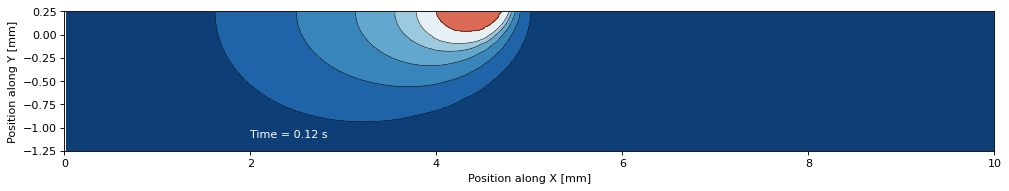

In [ ]:
framenum = 120
lev = [30,200,400,600,800,1000,1600,2800] #contour levels in kelvin
plot_contourlegend = False #Set = True is want the tempeature scale bar for the contours


plotFE(fnames_fast,framenum,plot_contourlegend)

### Movie!

This allows you to plot a movie from contour plots of the simulation - x direction is direction of beam travel, y-direction is the thickness. The viewed plane is in the centre of the beam. To run, choose the temperature contours by changing 'Lev'. Note, temperatures are in kelvin.

Note that you can also save the resulting movie as an mp4 file by changing SAVE_ANIMATION to True.

NOTE 1:  This takes a couple of minutes to run so be patient
NOTE 2:  For some reason it plots a single still of the first frame.  Not sure why.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: No contour levels were found within the data range.


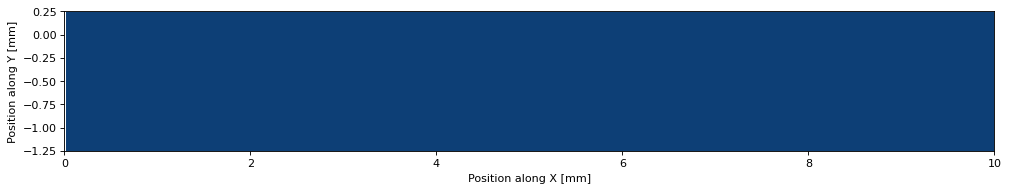

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: No contour levels were found within the data range.


In [ ]:
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML

SAVE_ANIMATION = False

lev = [30,200,400,600,800,1000,1600,2800]
    
xx,yy,TT,t = readfiles(fnames_fast[2],-1)

triang = tri.Triangulation(xx, yy)
interpolator = tri.LinearTriInterpolator(triang, TT)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1,1,1)
#cf = ax1.contourf(xi, yi, zi, levels=lev, cmap="RdBu_r")


ax1.set_ylim(-1.25,0.25)
plt.xlabel('Position along X [mm]')
plt.ylabel('Position along Y [mm]')
ax1.set_aspect('equal', adjustable='box')

cf = ax1.contourf(xi, yi, zi, levels=lev, cmap="RdBu_r")#, linewidths=0.5, colors='k')
c = ax1.contour(xi, yi, zi, levels=lev,linewidths=0.5, colors='k')  

def animate(i):
    """Set the data for the ith iteration of the animation."""

    global cf, c 
    xx,yy,TT,t = readfiles(fnames_fast[i],-1)
    triang = tri.Triangulation(xx, yy)
    interpolator = tri.LinearTriInterpolator(triang, TT)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    # Update the plot objects: remove the previous collections to save memory.
    for coll in cf.collections:
        coll.remove()
    cf = ax1.contourf(xi, yi, zi, levels=lev,cmap="RdBu_r")#, linewidths=0.5, colors='k')
    for coll in c.collections:
        coll.remove()
    c = ax1.contour(xi, yi, zi, levels=lev,linewidths=0.5, colors='k')

    return cf,c

if SAVE_ANIMATION:
    anim = animation.FuncAnimation(fig, animate, frames=100, interval=200, repeat=False)
    f = r"animation.mp4" 
    writervideo = animation.FFMpegWriter(fps=5) 
    anim.save(f, writer=writervideo)
else:
    anim = animation.FuncAnimation(fig, animate,frames=len(fnames_fast),interval=400)
    plt.show()

#anim = animation.FuncAnimation(fig, animate, frames=100, interval=200)

HTML(anim.to_html5_video())

PLOT! 

The cell below plots the 'cumulative melt pool'.  This is the position where the material was liquid at some point in the simulation.  Imagine this as what you would see if you did metallography - the blue region is what you would see as the (prior) melt pool experimentally

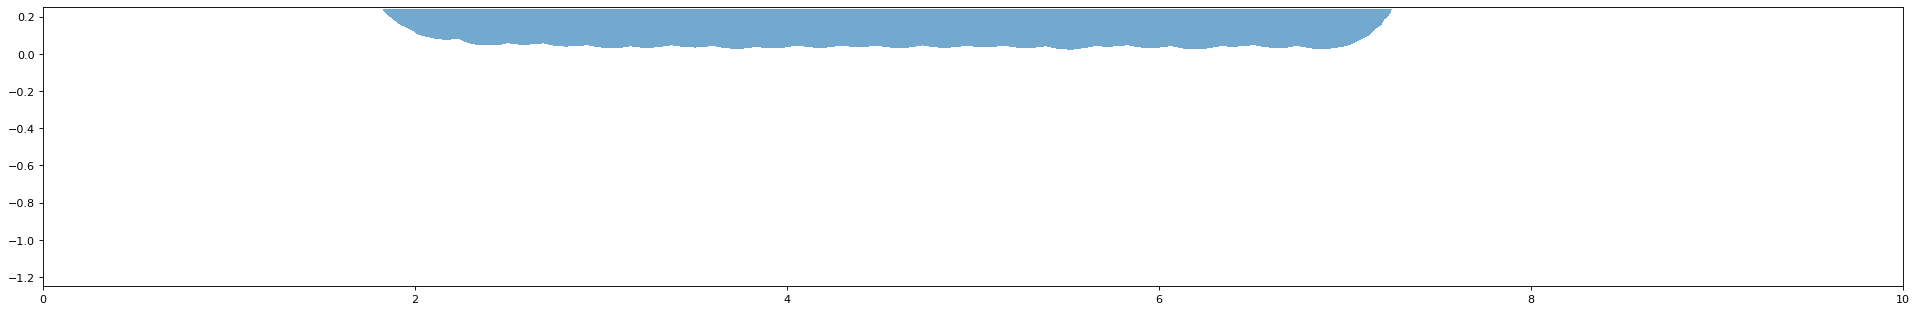

In [ ]:
fig=plt.figure(figsize=(30, 10), dpi= 80, facecolor='w', edgecolor='k')

ax0 = fig.add_subplot(1,1,1)
ax0.set_ylim(-1.25,0.25)
ax0.set_aspect('equal', adjustable='box')

for i in fnames_fast:

    xx,yy,TT,t = readfiles(i,-1)
    triang = tri.Triangulation(xx, yy)
    interpolator = tri.LinearTriInterpolator(triang, TT)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    cf = ax0.contourf(xi, yi, zi, [1670,3000],cmap='PuBu')


Cell below gets the maximum melt track depth as a function of time.  Be patient - this takes a bit of time to run

In [ ]:
FEmpdepth = []
for ind in range(len(timetot)):
  getFEdata(fnames_fast,ind)

# print(FEmpdepth) #sanity check to see if they are increasing each index
# len(FEmpdepth)

Cell below plots the melt pool depth as a function of time and position during the run.  Change the line 'continuous' to true or false depending on the conditions used.

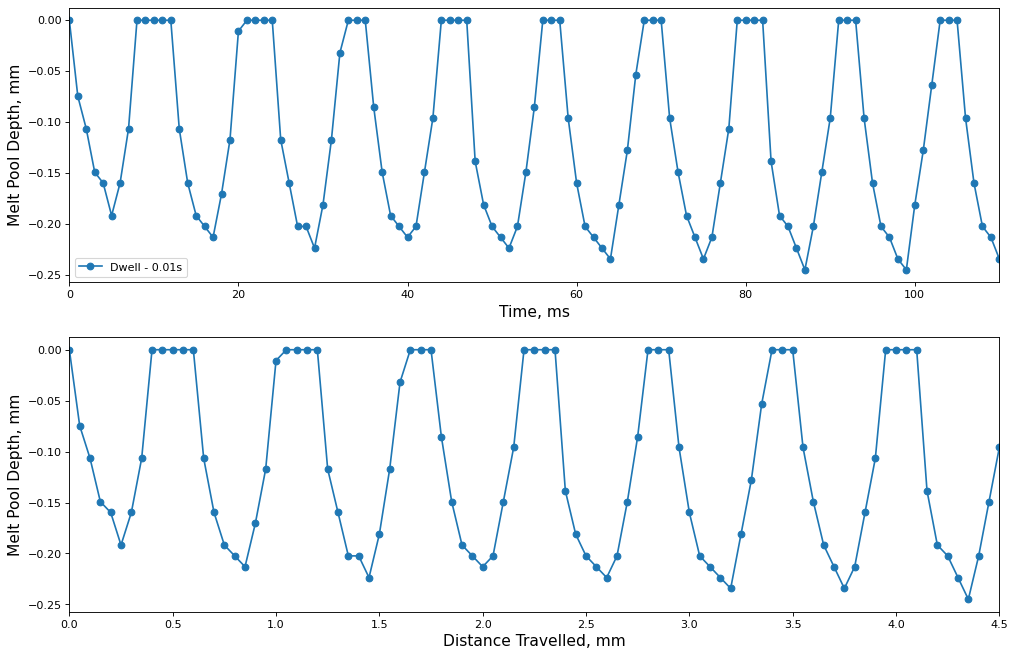

In [ ]:
#change to false for pulseated and use the subsequent blocks of code to get MP vs. distance
continuous = True


#######################START PLOTING HERE######################
strt = 0
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax0 = fig.add_subplot(2,1,1)

d = [-1*x for x in FEmpdepth] 
#d.pop(0)     
tme = [x*1000 for x in timetot[strt:]]

ax0.plot(tme,d,'o-',label='Dwell - 0.01s')
ax0.set_xlim(0,110)
ax0.set_xlabel('Time, ms',fontsize=14)
ax0.set_ylabel('Melt Pool Depth, mm',fontsize=14)
ax0.legend()

speed = 3000 #mm/min
if continuous:
  xdist = [t*(3000/60) for t in timetot[strt:]]
  ax1 = fig.add_subplot(2,1,2)
  ax1.plot(xdist,d,'o-',label='Speed = ')
  ax1.set_xlim(0,4.5)
  ax1.set_xlabel('Distance Travelled, mm',fontsize=14)
  ax1.set_ylabel('Melt Pool Depth, mm',fontsize=14)

In [ ]:
######################################## CODE TO GET EACH MP AT DISTANCE ###########################################

In [ ]:
travelD = 0.25 #mm
delta = 0.1*travelD #re-trace distance
time2D = 0.005 #s 
speed = travelD/time2D #mm/s
dwell = 0.01 #s

MPgrad = getMPgrad(FEmpdepth)

In [ ]:
MPind = [x for x in range(len(MPgrad)) if MPgrad[x]<0]

In [ ]:
MPlocs = getMPlocs(MPind)
for key, value in MPlocs.items():
  print(key, '->', value)

MP1 -> [0, 1, 2, 3, 4]
MP2 -> [16, 17, 18, 19]
MP3 -> [31, 32, 33, 34]
MP4 -> [46, 47, 48, 49, 50]
MP5 -> [61, 62, 63, 64, 65]
MP6 -> [76, 77, 78, 79, 80]
MP7 -> [91, 92, 93, 94, 95]
MP8 -> [107, 108, 109, 110]
MP9 -> [122, 123, 124, 125]
MP10 -> [137, 138, 139, 140]


In [ ]:
distMP = {}
count=1
mult = 0
for key, value in MPlocs.items():
  #print(len(value))
  distance = []
  #for k in value:
  d_list = list(np.linspace((0+(travelD-delta)*mult),(0+(travelD-delta)*mult+travelD),len(value)+1))
  distMP["dist"+str(count)] = d_list
  count+=1
  mult+=1

NameError: ignored

In [ ]:
MPtot_d = []
count = 1
for keyval, value in MPlocs.items():
  MP_d = []
  for indices in range(len(value)):
    MP_d.append(-1*FEmpdepth[MPlocs["MP"+str(count)][indices]])
  MP_d.append(-1*FEmpdepth[MPlocs["MP"+str(count)][indices]+1])
  MPtot_d.append(MP_d)
    #plt.scatter(distMP["dist"+str(count)][indices],-1*FEmpdepth[MPlocs["MP"+str(count)][indices]])
  count+=1
key_list = list(MPlocs.keys())
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax0 = fig.add_subplot(2,1,1)
for count in range(1,len(distMP)+1):
  ax0.plot(distMP["dist"+str(count)],MPtot_d[count-1],'-o',color='black',label = key_list[count-1])


ax0.set_xlabel('Distance, mm',fontsize=14)
ax0.set_ylabel('Melt Pool Depth, mm',fontsize=14)
#ax0.legend()


NameError: ignored